# Building the data

This notebook is for building the data that the rest of them will use

Let's see if we can get the images from voynichese.com site

In [12]:
from vdata import Voynich

def downloadImages():
    a = Voynich()
    import urllib

    save_dir = 'image/'
    base_url = 'http://www.voynichese.com/2/data/folio/image/glance/color/large/'

    for folio in a.folios:
        img_name = '{}.jpg'.format(folio)
        url = base_url + img_name
        urllib.request.urlretrieve(url, save_dir + img_name)    



So we get this data from voynichese.com. One file for each page, and they look like this!

f100r.xml

```
<folio name="f100r" wordCount="111" width="1083" height="1500">
  <word index="0" x="159" y="84" width="105" height="31">chosaroshol</word>
  <word index="1" x="280" y="69" width="93" height="44">sochorcfhy</word>
  ...
  ...
```

In [92]:
from bs4 import BeautifulSoup
import pandas as pd
import re
import itertools

DIR = 'data/'

# --------------- for working with the data/takeshi.txt file ----------------
def process(line):
    line = line.strip()
    line = re.sub('-','.',line)
    line = re.sub('[\!<>\*\=\%]', '', line)
    header, line = line.split(' ', maxsplit=1)
    header = re.sub('[;\.]', ' ', header).split()
    line = line.replace('.',' ')
    return header, line.strip()

def pdFromFile(filename):
    with open(DIR + filename) as f:
        lines = f.readlines()

        df = []
        for line in lines:
            header, text = process(line)
            df.append({
                'folio': header[0],
                'paragraph': header[1],
                'line': header[2],
                'text': text,
            })
        
    return pd.DataFrame(df)

    
def VoynichOrdering(folio_name):
    """
    only used as an argument to sort()
    """
    page, part = re.match('f(\d+)(.+)', folio_name).groups()
    page = int(page)
    return page, part


class Voynich:
    """
    contains a dataFrame of all the folios (w/ line and paragraph numbers)
    with utility methods to get words and lines from a single folio
    """
    
    def __init__(self):
        self.data = pdFromFile('takeshi.txt')
        self.folios = sorted(set(self.data.folio), key=VoynichOrdering)
        
    def getWords(self, number):
        return ' '.join(self.getLines(number))
    
    def getLines(self, number):
        lines = list(self.data[self.data.folio == number].text)
        return lines
    

# ------------------------ for working with data/*.xml files -------------------
import os
from pathlib import Path
class Folio:
    
    voynich = Voynich()
    
    def __init__(self, name):
        self.name = name
        
        self.data = None
        
        self.filename = Path(os.path.join(DIR, name + '.xml'))
        if self.filename.exists():
            self.readData()
        else:
            print('no file exist')
    
    def readData(self):
         with open(self.filename,"r") as infile:
            contents = infile.read()

            # build pandas dict
            soup = BeautifulSoup(contents,'xml')
            titles = soup.find_all('word')

            def parse(t):
                a = dict()
                for prop in ['x', 'y', 'width', 'height']:
                    a[prop] = int(t[prop])
                a['word'] = t.get_text()
                return a

            data = [parse(t) for t in titles]
            self.data = pd.DataFrame(data)
            
            self.wordcount = int(soup.find('folio')['wordCount'])
        
    
    @property
    def lines(self):
        return Folio.voynich.getLines(self.name)
            
    @property
    def text(self):
        if self.data is not None:
            return ' '.join(self.data.word)


In [93]:
Folio('f1r').lines

['fachys ykal ar ataiin shol shory cthres y kor sholdy',
 'sory ckhar or y kair chtaiin shar are cthar cthar dan',
 'syaiir sheky or ykaiin shod cthoary cthes daraiin sa',
 'ooiin oteey oteos roloty cthar daiin otaiin or okan',
 'dair y chear cthaiin cphar cfhaiin',
 'ydaraishy',
 'odar o y shol cphoy oydar sh s cfhoaiin shodary',
 'yshey shody okchoy otchol chocthy oschy dain chor kos',
 'daiin shos cfhol shody',
 'dain os teody',
 'ydain cphesaiin ol s cphey ytain shoshy cphodales',
 'oksho kshoy otairin oteol okan shodain sckhey daiin',
 'shoy ckhey kodaiin cphy cphodaiils cthey she oldain d',
 'dain oiin chol odaiin chodain chdy okain dan cthy kod',
 'daiin shckhey ckeor chor shey kol chol chol kor chal',
 'sho chol shodan kshy kchy dor chodaiin sho kchom',
 'ycho tchey chokain sheo pshol dydyd cthy daicthy',
 'yto shol she kodshey cphealy dasain dain ckhyds',
 'dchar shcthaiin okaiir chey rchy potol cthols dlocta',
 'shok chor chey dain ckhey',
 'otol daiiin',
 'cpho shaiin shokch

In [95]:
Folio('f1r').text

'fachys ykal ar ataiin shol shory cthres y kor sholdy sory ckhar or y kair chtaiin shar are cthar cthar dan syaiir sheky or ykaiin shod cthoary cthes daraiin sa ooiin oteey oteos roloty cthar daiin otaiin or okan dair y chear cthaiin cphar cfhaiin ydaraishy odar o y shol cphoy oydar sh s cfhoaiin shodary yshey shody okchoy otchol chocthy oschy dain chor kos daiin shos cfhol shody dain os teody ydain cphesaiin ol s cphey ytain shoshy cphodales oksho kshoy otairin oteol okan shodain sckhey daiin shoy ckhey kodaiin cphy cphodaiils cthey she oldain d dain oiin chol odaiin chodain chdy okain dan cthy kod daiin shckhey ckeor chor shey kol chol chol kor chal sho chol shodan kshy kchy dor chodaiin sho kchom ycho tchey chokain sheo pshol dydyd cthy daicthy yto shol she kodshey cphealy dasain dain ckhyds dchar shcthaiin okaiir chey rchy potol cthols dlocta shok chor chey dain ckhey otol daiiin cpho shaiin shokcheey chol tshodeesy shey pydeey chy ro d doin chol dain cthal dar shear kaiin dar shey

In [98]:
def checkIntegrity():
    a = Voynich()
    for f in a.folios:
        arr1, arr2 = a.getWords(f).split(), Folio(f).text.split()
        assert arr1 == arr2

# checkIntegrity()
# yes! all the folios match up!

Now we can do things like select by paragraph

In [61]:
import itertools

a = Voynich()
# join by paragraph
paragraphs = a.data.groupby(['folio', 'paragraph']).agg({
    'text': '\n'.join
}).to_dict()['text']

for k,v in itertools.islice(paragraphs.items(), 20):
    print(k, len(v.split()), 'words', v.split()[:5])

('f100r', 'L1') 7 words ['chosaroshol', 'sochorcfhy', 'otear', 'chofary', 'sar']
('f100r', 'L2') 6 words ['osaro', 'chalsain', 'soity', 'sosam', 'dakocth']
('f100r', 'L3') 6 words ['okeeos', 'shockhey', 'orol', 'olcheom', 'okols']
('f100r', 'P1') 36 words ['pcheol', 'sheod', 'qocpheeckhy', 'shodol', 'cthdaoto']
('f100r', 'P2') 56 words ['folshody', 'chol', 'daiin', 'fchodycheol', 'cphol']
('f100v', 'B') 5 words ['okcheor', 'ytchol', 'dykchal', 'chos', 'cthoral']
('f100v', 'M') 6 words ['sol', 'eesos', 'ykchochdy', 'ykchdy', 'dchdy']
('f100v', 'P') 76 words ['cthdeecthy', 'sheocphy', 'qoteody', 'ckhoor', 'ar']
('f100v', 'T') 4 words ['tolchd', 'chols', 'opchor', 'rolsy']
('f101r1', 'P') 209 words ['pcheol', 'cheol', 'ol', 'shey', 'qockhol']
('f101v2', 'P') 185 words ['tolchor', 'cheopor', 'or', 'ody', 'cpheyr']
('f101v2', 'R1') 9 words ['sairaly', 'otaldy', 'otal', 'yta', 'dokor']
('f101v2', 'R2') 10 words ['okol', 'arom', 'orar', 'am', 'or']
('f101v2', 'T') 9 words ['teol', 'cheol', 'e

# BELOW THIS IS NOT REALLY USEFUL

## Repeating phrases in the manuscript

In [106]:
import nltk

In [107]:
text = 'hi i saw a dog'
bigrm = list(nltk.bigrams(text.split()))
bigrm

[('hi', 'i'), ('i', 'saw'), ('saw', 'a'), ('a', 'dog')]

In [108]:
from collections import defaultdict, Counter


?defaultdict

Init signature: defaultdict(self, /, *args, **kwargs)
Docstring:     
defaultdict(default_factory[, ...]) --> dict with default factory

The default factory is called without arguments to produce
a new value when a key is not present, in __getitem__ only.
A defaultdict compares equal to a dict with the same items.
All remaining arguments are treated the same as if they were
passed to the dict constructor, including keyword arguments.
File:           ~/anaconda3/lib/python3.6/collections/__init__.py
Type:           type


In [109]:
locations = defaultdict(list)
counts = Counter()
def add(bigrams):
    counts.update([x[0] for x in bigrams])
    for x,folio,line in bigrams:
        locations[x] += [(folio, line)]
        
for index, row in takeshi.iterrows():
    folio, line, paragraph, text = row['folio'], row['line'], row['paragraph'], row['text']
    bigrm = list(nltk.bigrams(text.split()))
    bigrm = [(x, folio, line) for x in bigrm]
    add(bigrm)


In [117]:
len(locations[('or', 'aiin')])

51

## Minimal pairs

In [126]:
from nltk.metrics.distance import edit_distance

In [127]:
edit_distance('chedy', 'shedy')

1

In [120]:
tokens = nltk.word_tokenize(voynich_text)
unique_words = list(set(tokens))
print(len(unique_words))

8493


In [129]:
def searchForClose(word):
    minpairs = [w for w in unique_words if edit_distance(w, word) == 1]
    return minpairs

searchForClose('chedy')[:5]

['cphedy', 'kchedy', 'ochedy', 'chydy', 'chesy']

In [130]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(unique_words)

for w1 in unique_words:
    for w2 in searchForClose(w1):
        G.add_edge(w1, w2)

KeyboardInterrupt: 

In [ ]:
import graphviz as gv

In [73]:
counts.most_common(20)

[(('or', 'aiin'), 51),
 (('chol', 'daiin'), 33),
 (('s', 'aiin'), 28),
 (('ar', 'al'), 23),
 (('shedy', 'qokedy'), 21),
 (('ar', 'aiin'), 21),
 (('ol', 'chedy'), 21),
 (('ol', 'shedy'), 21),
 (('chol', 'chol'), 19),
 (('qol', 'chedy'), 19),
 (('chedy', 'qokeey'), 19),
 (('shedy', 'qokaiin'), 18),
 (('chedy', 'qokain'), 18),
 (('qokeedy', 'qokeedy'), 18),
 (('daiin', 'daiin'), 17),
 (('shey', 'qokain'), 17),
 (('shedy', 'qokeedy'), 16),
 (('chedy', 'qokedy'), 14),
 (('chedy', 'qol'), 14),
 (('daiin', 'chey'), 13)]

These are a superset of the labels

https://github.com/voynichese/voynichese/blob/wiki/Experiments.md#label-words

In [7]:
# takeshi[takeshi.paragraph.str.contains('T')]

In [8]:
takeshi.iloc[4030].text

'teol cheol ekcheyor cheol cthol cholaiin chol qkos'

## Running an HMM

In [182]:
import pickle
import pystan

# bernoulli model
model_code = """
    data {
      int<lower=0> N;
      int<lower=0,upper=1> y[N];
    }
    parameters {
      real<lower=0,upper=1> theta;
    }
    model {
      for (n in 1:N)
          y[n] ~ bernoulli(theta);
    }
    """
data = dict(N=10, y=[0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
model = pystan.StanModel(model_code=model_code)
fit = model.sampling(data=data)

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

# load it at some future point
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

# run with different data
fit = model.sampling(data=dict(N=5, y=[1, 1, 0, 1, 0]))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ed12b60d4e79f489850662e92c114122 NOW.


In [184]:
fit

Inference for Stan model: anon_model_ed12b60d4e79f489850662e92c114122.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.58  5.0e-3   0.17   0.24   0.46   0.59    0.7   0.87   1166    1.0
lp__   -5.28    0.02   0.69  -7.26  -5.45   -5.0  -4.83  -4.78   1706    1.0

Samples were drawn using NUTS at Sat Apr 21 23:39:32 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [ ]:
fit.

In [185]:
import numpy as np

x_train = np.linspace(-3, 3, num=50)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype(np.float32).reshape((50, 1))
y_train = y_train.astype(np.float32).reshape((50, 1))

In [ ]:
1

In [ ]:
import tensorflow as tf
from edward.models import Normal

W_0 = Normal(loc=tf.zeros([1, 2]), scale=tf.ones([1, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = x_train
y = Normal(loc=tf.matmul(tf.tanh(tf.matmul(x, W_0) + b_0), W_1) + b_1,
           scale=0.1)

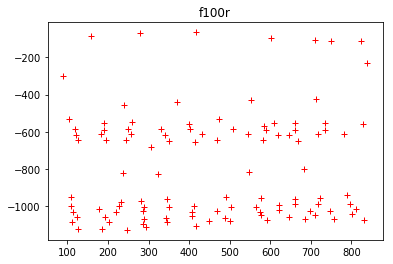

In [115]:
# helpful methods

def showLocations(a):
    """
    params
        a: Folio
    returns: picture of the word positions
    """
    x,y = a.data.x, a.data.y
    plt.plot(x,-y, 'r+')
    plt.title(a.name)
    plt.show()

In [97]:
a.words

'chosaroshol sochorcfhy otear chofary sar char daiindy osaro chalsain soity sosam dakocth sofal pcheol sheod qocpheeckhy shodol cthdaoto ch qeos sheey chcthso s dsheor cthey qokeey oteey ykeeodain sorary daiin daiin deeamshol shor chkeey qoteey qokeody qoteold qokeol so raiin otal ykecho dcheor shol qokeeol chor chol qokeeody dorean okeeos shockhey orol olcheom okols oteol folshody chol daiin fchodycheol cphol qotees shey oreso alcfhy soiin chol cphol shol shol qockhol chor chol sho keey cckhhy ykeeam saiichor sheor qockhody odeor yksheey chol sheody sai cheol raiin sheor qkeeody chol daiin ctheol olcheol cheky cheol cheockhy okeol yaiin chekeey chol cholody chos olchor qokeol okeeol cheols al chol cheol cho chckheody otolchey'